In [95]:
import numpy as np
from pandas import read_csv

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import re
import nltk.corpus
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence

In [25]:
def clean(text):

    text = text.lower()

    # remove urls and html tags
    # needs to happen before removing punctuations
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub('<.*?>+', ' ', text)

    # remove punctuations and unicodes
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)

    # removes stop words and extra spaces
    # lemmatises every word
    stop = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop])

    return text

df = read_csv('imdb_dataset.csv')
df['review'] = df['review'].apply(lambda text: clean(text))
mapping = { 'positive' : 1, 'negative': 0 }
df = df.replace({ 'sentiment': mapping })

In [311]:
tokenizer = get_tokenizer("basic_english")
tokens = [tokenizer(doc) for doc in df['review']]
voc = build_vocab_from_iterator(tokens, specials=["<unk>"], max_tokens=1000)
voc.set_default_index(voc['<unk>'])

In [312]:
tokenised_reviews = [voc(token) for token in tokens]

In [348]:
# data

BATCH_SIZE = 4

def collate(batch):

    reviews = [torch.tensor(review) for (review, _) in batch]
    reviews = pad_sequence(reviews, batch_first=True)
    labels = torch.tensor([label for (_, label) in batch])

    return reviews, labels

class ImdbDataset(Dataset):

    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels

    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        return (self.reviews[idx], self.labels[idx])

train_dataloader = DataLoader(ImdbDataset(tokenised_reviews[:40000], df['sentiment'][:40000]), shuffle=True, batch_size=BATCH_SIZE, drop_last=True, collate_fn=collate)
# test_dataloader = DataLoader(ImdbDataset(df[45000:]), shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

t - sequence length
k - word embedding dimension
b - batch size
h - number of heads in multi headed attention 

In [349]:
device = 'cuda'

In [350]:
class MutliHeadedAttention(nn.Module):

    def __init__(self, k, h):
        super().__init__()
        self.k = k
        self.h = h

        self.queries_converter = nn.Linear(k, h*k)
        self.keys_converter =  nn.Linear(k, h*k)
        self.values_converter =  nn.Linear(k, h*k)

        self.combine_heads = nn.Linear(h*k, k)
    
    def forward(self, x):
        
        # x.shape = [b, t, k]
        b, t, _ = x.shape
        h, k = self.h, self.k

        # q, k, v shape = [b, t, h*k]
        queries = self.queries_converter(x)
        keys = self.keys_converter(x)
        values = self.values_converter(x)

        # [b, t, h*k] - [b, t, h, k] - [b, h, t, k] - [b*h, t, k]
        # tranpose is necessary because only adjacent dimensions can be clubbed
        # the final shape is needed to apply bmm without losing the h dimension
        queries = queries.view(b, t, h, k).transpose(1, 2).contiguous().view(b*h, t, k)
        keys = keys.view(b, t, h, k).transpose(1, 2).contiguous().view(b*h, t, k)
        values = values.view(b, t, h, k).transpose(1, 2).contiguous().view(b*h, t, k)

        # [b*h, t, k] x [b*h, k, t]
        weights = torch.bmm(queries, keys.transpose(1, 2))

        # [b*h, t, t]
        # softmax applied across the second t dimension so that each row is normalised
        weights = F.softmax(weights, dim=2)

        # [b*h, t, k]
        multi_attention = torch.bmm(weights, values)

        # [b*h, t, k] - [b, h, t, k] - [b, t, h, k] - [b, t, h*k]
        multi_attention = multi_attention.view(b, h, t, k).transpose(1, 2).contiguous().view(b, t, h*k)

        # attention.shape = [b, t, k]
        attention = self.combine_heads(multi_attention)

        return attention

def encode_positions(t, k):

    # accepts sequence length and token length
    position_encoding = torch.zeros((t, k))
    for j in range(t):
        for i in range(k//2):
            val = torch.tensor(j/10000**((2*i/k)))
            position_encoding[j,2*i] = val.sin()
            position_encoding[j,2*i+1] = val.cos()
    
    return position_encoding.to(device)

class TransformerBlock(nn.Module):

    def __init__(self, k, h):
        super().__init__()
        self.layernorm1 = nn.LayerNorm(k)
        self.layernorm2 = nn.LayerNorm(k)
        self.multiattention = MutliHeadedAttention(k, h)
        self.mlp = nn.Sequential(
            nn.Linear(k, 4*k),
            nn.ReLU(),
            nn.Linear(4*k, k)
        )
    
    def forward(self, x):

        y = self.multiattention(x)
        y = self.layernorm1(y)
        x = x + y

        y = self.mlp(x)
        y = self.layernorm2(y)
        x = x + y

        return x

class Transformer(nn.Module):

    # binary classification

    def __init__(self, t = 100, k = 64, h = 8):
        super().__init__()
        vocab_size = 1000
        self.embedding = nn.Embedding(vocab_size, k)
        self.position_encodings = encode_positions(2000, k)
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(k, h) for _ in range(2)])
        self.linear = nn.Linear(k, 1)

    def forward(self, x):

        x = self.embedding(x)
        x = x + self.position_encodings[:x.shape[1],:]
        x = self.transformer_blocks(x)
        x = x.mean(dim=1)
        x = self.linear(x)
        # x = torch.sigmoid(x)

        return x

In [351]:
model = Transformer().to(device)
model.train()
optimiser = torch.optim.Adam(model.parameters(), lr=0.0002)
criterion = nn.BCEWithLogitsLoss()

In [352]:
EPOCHS = 10

losses = [1]

for epoch in range(EPOCHS):
    for i, data in enumerate(train_dataloader):

        optimiser.zero_grad()

        review, label = data
        review, label = review.to(device), label.to(device)
        predicted_label = model(review).squeeze(1)

        loss = criterion(predicted_label.float(), label.float())
        # print(predicted_label.float(), label.float())
        loss.backward()
        losses.append(0.9*losses[-1] + 0.1*loss.cpu().detach().numpy())

        # print(label.float(), predicted_label.float(), loss)

        # nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimiser.step()

        # if 1 or i%10 == 0: print(losses[-1])
    print(losses[-1])

0.5075623951088427
0.34576123359544225
0.4015528459669372
0.4219210084394183
0.37422395893747556
0.3506436097343595
0.23773466897413523
0.25047358625145966
0.2678773581228292
0.18478889611683036


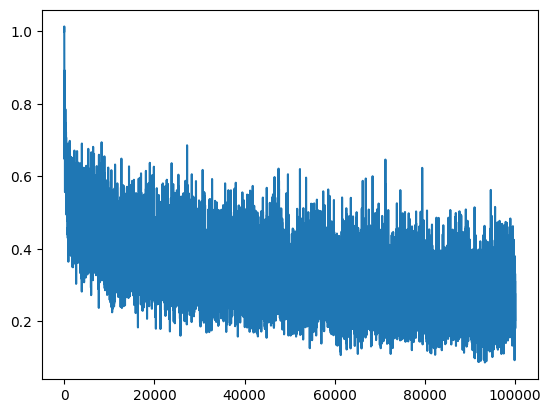

In [353]:
plt.plot(list(range(len(losses))), losses)
plt.show()

In [357]:
# validation

accuracy = 0
val_dataloader = DataLoader(ImdbDataset(tokenised_reviews[40000:45000], df['sentiment'].to_numpy()[40000:45000]), shuffle=True, batch_size=2, drop_last=True, collate_fn=collate)

for i, data in enumerate(val_dataloader):

    review, label = data
    review, label = review.to(device), label.to(device)
    predicted_label = torch.sigmoid(model(review)).squeeze(1) > 0.5

    # print(predicted_label, label)

    accuracy += np.sum(predicted_label.cpu().detach().numpy() == label.cpu().detach().numpy())
    # tp =
    # fp =

accuracy /= 5000


In [358]:
accuracy

0.8352

2500

In [ ]:
# train acc 0.923825
# train acc 0.8352


In [361]:
doc_frequency = defaultdict(lambda: 0)
for doc in df['review']:
    words, counts = np.unique(doc.split(), return_counts=True)
    for word in words: doc_frequency[word] += 1


'one reviewer mentioned watching 1 oz episode youll hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home manyaryans muslim gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show wouldnt dare forget pretty picture painted mainstream audience forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard wholl sold nickel inmate wholl kill order get away well mannered middle class inmate turned prison bitch due 

In [375]:
document_frequency = np.zeros((1000))
num_docs = len(tokenised_reviews)
word_frequency = np.zeros((num_docs, 1000))
for i, review in enumerate(tokenised_reviews):
    unique_tokens, counts = np.unique(review, return_counts=True)
    if len(unique_tokens) == 0: continue
    word_frequency[i][unique_tokens] += counts
    document_frequency[unique_tokens] += 1

In [376]:
np.dot(word_frequency, np.log(num_docs/(document_frequency+1))).shape

(50000,)

In [377]:
word_frequency.shape

(50000, 1000)

In [379]:
np.log(num_docs/(document_frequency+1)).shape

(1000,)

In [382]:
tfidf = (word_frequency*np.log(num_docs/(document_frequency+1)))

(1000,)